# Projeto A.R.P.I.A.

Objetivo do projeto é criar uma rede neural capaz de identificar e classificar uma imagem de raio-x e identificar se o paciente tem ou não pneumonia

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Importação das bibliotecas

In [2]:
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import sklearn
from keras.preprocessing.image import ImageDataGenerator

## Definindo parametros randômicos

In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Importação da base de Dados

In [4]:
def obter_dados_treinamento(diretorio, rotulos, tamanho):
    dataset = []
    for rotulo in rotulos:
        caminho = os.path.join(diretorio, rotulo)
        index = rotulos.index(rotulo)
        for img in os.listdir(caminho):
            try:
                imagem = cv2.imread(os.path.join(caminho, img), cv2.IMREAD_GRAYSCALE)
                imagem_redimensionada = cv2.resize(imagem, (tamanho, tamanho))
                equ = cv2.equalizeHist(imagem_redimensionada) 
                #res = np.hstack(equ) 
                #dst = cv2.GaussianBlur(imagem_redimensionada,(5,5),cv2.BORDER_DEFAULT)
                #dataset.append([dst, index])
                dataset.append([equ, index])
            except Exception:
                pass
    array = np.array(dataset)
    return dataset 

In [5]:
rotulos = ['PNEUMONIA', 'NORMAL']
train = obter_dados_treinamento('C:\\Users\\Lucas Otavio\\Desktop\\Faculdade\\2\\Oficina\\chest_xray\\chest_xray\\train', rotulos, 300)
teste = obter_dados_treinamento('C:\\Users\\Lucas Otavio\\Desktop\\Faculdade\\2\\Oficina\\chest_xray\\chest_xray\\test', rotulos, 300)
val = obter_dados_treinamento('C:\\Users\\Lucas Otavio\\Desktop\\Faculdade\\2\\Oficina\\chest_xray\\chest_xray\\val', rotulos, 300)

C:\Users\Lucas Otavio\AppData\Local\Temp\ipykernel_17884\2252522599.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(dataset)


### Separando as imagens e os labels

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

for dados in train:
    X_train.append(dados[0])
    y_train.append(dados[1])
    
for dados in teste:
    X_test.append(dados[0])
    y_test.append(dados[1])

for dados in val:
    X_val.append(dados[0])
    y_val.append(dados[1])

## Análisar o dataset

In [7]:
print(f'Label: {train[0][1]}')
print(f'Image Pixel Array:\n{train[0][0]}')

Label: 0
Image Pixel Array:
[[21 21 23 ...  4  2  0]
 [21 22 23 ...  5  3  0]
 [21 22 23 ...  6  4  0]
 ...
 [10 10 10 ... 16 16 16]
 [10 10 10 ... 16 16 16]
 [10 10 10 ... 16 16 16]]


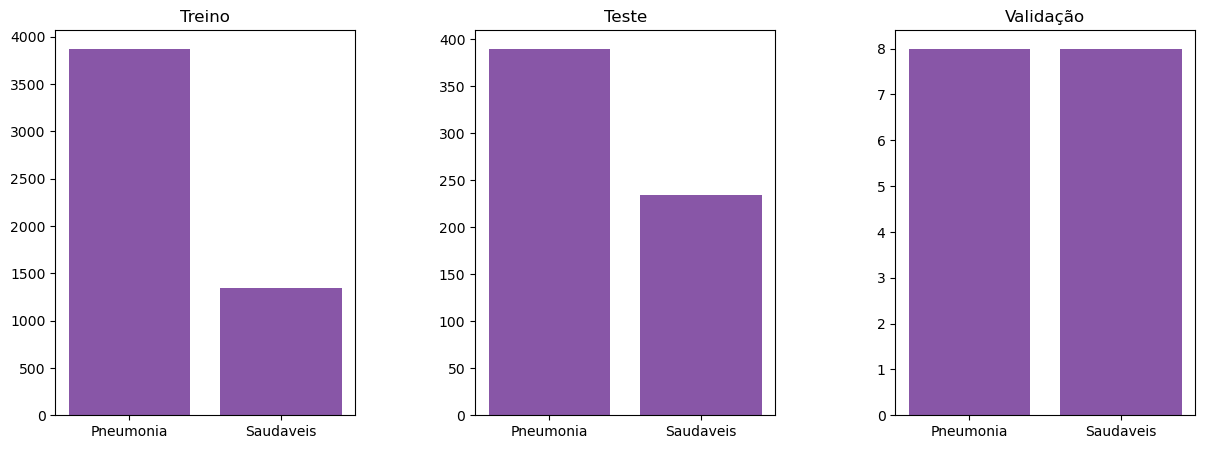

In [8]:
plt.figure(figsize=(6, 5))
plt.subplots_adjust(left=0.1, right=2, wspace=0.4, hspace=0.4)
lista = [y_train, y_test, y_val]
title = ['Treino', 'Teste', 'Validação']
x = ['Pneumonia', 'Saudaveis']
for i, item in enumerate(lista):
    y = [item.count(0), item.count(1)]
    ax = plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.bar(x, y, color='#8856a7')

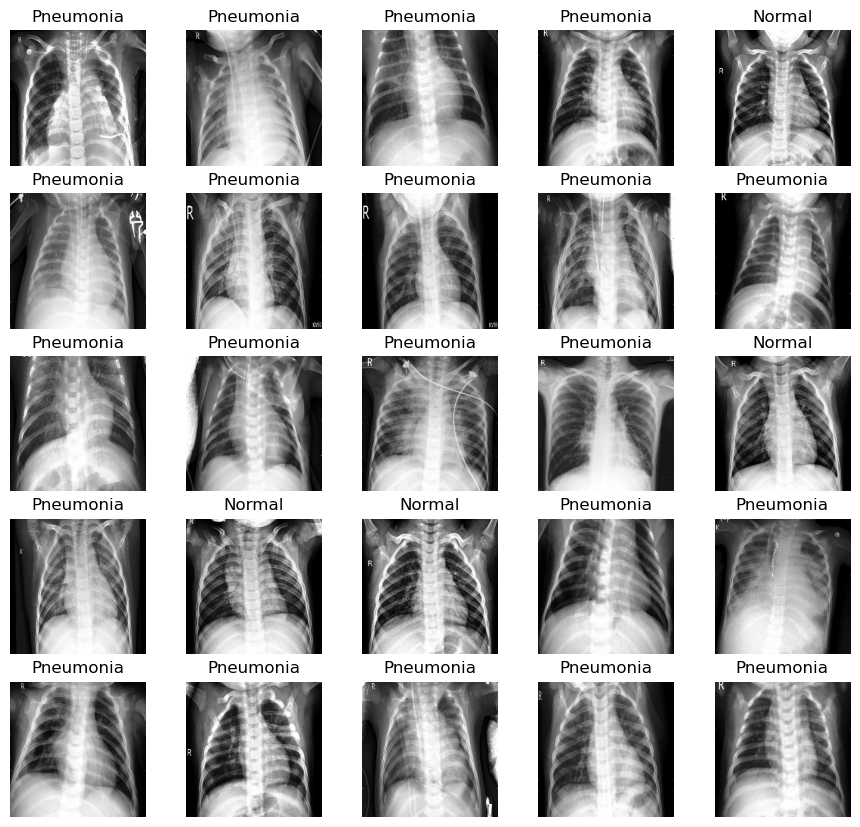

In [9]:
x = np.random.randint(1,5000,(1,25))
x = x[0]
plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.1, right=.8, wspace=0.3, hspace=0.1, bottom=0.001, top=1)
for i, ran in enumerate(x):
    ax = plt.subplot(5, 5, i+1)
    if y_train[ran] == 0:
        plt.title('Pneumonia')
    else:
        plt.title('Normal')
    plt.axis('off')
    plt.imshow(X_train[ran], cmap='gray')
    if i+2 > 25:
        break

## Pré processamento

### Normalização dos Dados
Como a escala é cinza o maior valor será 255 (branco) e o menor será 0 (preto), mas só para garantir vamos fazer o teste

In [10]:
menor = min(train[0][0][0])
maior = max(train[0][0][0])
for lista in train[0][0]:
    if min(lista) < menor:
        menor = min(lista)
    if max(lista) > maior:
        maior = max(lista)

In [11]:
menor

0

In [12]:
maior

255

In [13]:
X_train_nor = np.divide(X_train, maior)
X_test_nor = np.divide(X_test, maior)
X_val_nor = np.divide(X_val, maior)

In [14]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [15]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
X_train_nor.shape

(5216, 300, 300)

In [17]:
np.set_printoptions(linewidth=100)
print(X_train_nor)

[[[0.08235294 0.08235294 0.09019608 ... 0.01568627 0.00784314 0.        ]
  [0.08235294 0.08627451 0.09019608 ... 0.01960784 0.01176471 0.        ]
  [0.08235294 0.08627451 0.09019608 ... 0.02352941 0.01568627 0.        ]
  ...
  [0.03921569 0.03921569 0.03921569 ... 0.0627451  0.0627451  0.0627451 ]
  [0.03921569 0.03921569 0.03921569 ... 0.0627451  0.0627451  0.0627451 ]
  [0.03921569 0.03921569 0.03921569 ... 0.0627451  0.0627451  0.0627451 ]]

 [[0.1254902  0.12941176 0.1372549  ... 0.05882353 0.05882353 0.05882353]
  [0.12941176 0.14117647 0.15686275 ... 0.06666667 0.05882353 0.05490196]
  [0.14117647 0.14509804 0.16078431 ... 0.05882353 0.05882353 0.05490196]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.01568627 0.02352941 0.02745098 ... 0.31372549 0.38823529 0.44313725]
  [0.02352941 0.031372

### Balanceando o dataset

In [18]:
normal = 0
pneumonia = 0
for valores in y_train:
    if valores == 0:
        pneumonia += 1
    else:
        normal += 1
        
bias_inicial = np.log([pneumonia/normal])
bias_inicial

array([1.06113006])

In [19]:
peso_pneumonia = (1 / pneumonia)*(normal+pneumonia)/2.0
peso_normal = (1 / normal)*(normal+pneumonia)/2.0 

class_weight = {0: peso_pneumonia, 1: peso_normal}

print(f'Peso normal: {peso_normal}')
print(f'Peso pneumonia: {peso_pneumonia}')

Peso normal: 1.9448173005219984
Peso pneumonia: 0.6730322580645162


## Data augmantation

In [20]:
# Redimensionando os dados
X_train_nor = X_train_nor.reshape(-1, 300, 300, 1)
X_val_nor = X_val_nor.reshape(-1, 300, 300, 1)
X_test_nor = X_test_nor.reshape(-1, 300, 300, 1)

In [21]:
datagen = ImageDataGenerator(
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True)

datagen.fit(X_train_nor)

## Desenvolvimento da Rede Neural

### Definindo Modelo

In [22]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
 ])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam"),metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 298, 298, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 dropout (Dropout)           (None, 147, 147, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 147, 147, 32)     1

## Treinando e Testando o Modelo

In [24]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [25]:
#history = model.fit(X_train_nor, y_train, epochs=6, validation_data=(X_val_nor, y_val), class_weight=class_weight)
history = model.fit(datagen.flow(X_train_nor, y_train), epochs=14, validation_data=datagen.flow(X_val_nor, y_val), class_weight=class_weight, callbacks = [learning_rate_reduction])

Epoch 1/14
163/163 [==============================] - 176s 1s/step - loss: 0.3880 - accuracy: 0.8328 - precision: 0.6291 - recall: 0.8523 - val_loss: 1.4584 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/14
163/163 [==============================] - 184s 1s/step - loss: 0.2762 - accuracy: 0.8819 - precision: 0.7149 - recall: 0.8993 - val_loss: 1.9847 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 3/14
163/163 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.8982 - precision: 0.7443 - recall: 0.9202
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
163/163 [==============================] - 176s 1s/step - loss: 0.2351 - accuracy: 0.8982 - precision: 0.7443 - recall: 0.9202 - val_loss: 2.4979 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 4/14
163/163 [==============================] 

In [26]:
print("Evaluate on test data")
results = model.evaluate(X_test_nor, y_test)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 3s 165ms/step - loss: 0.2761 - accuracy: 0.8878 - precision: 0.8361 - recall: 0.8718
test loss, test acc: [0.27610597014427185, 0.8878205418586731, 0.8360655903816223, 0.8717948794364929]


## Avaliando Modelo

### Treinamento

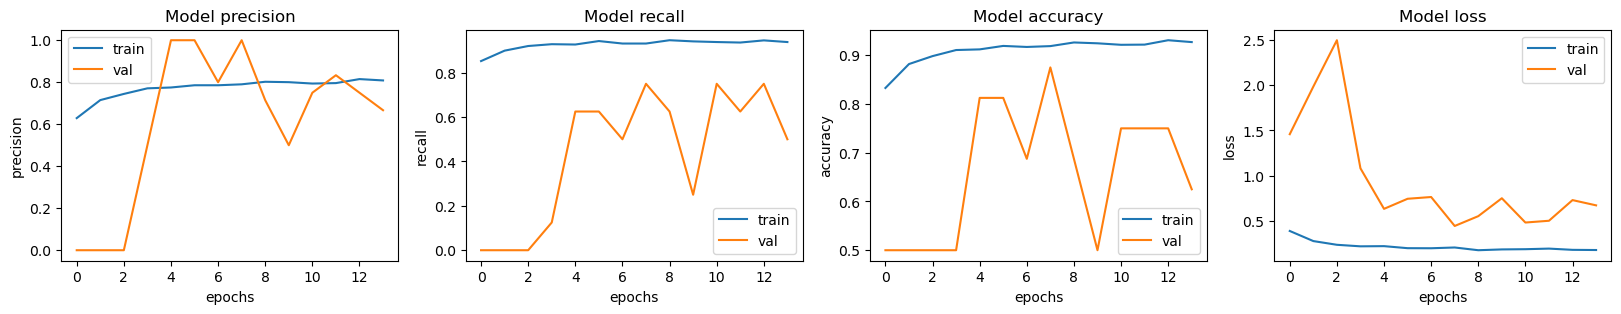

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Teste

In [28]:
y_pred = model.predict(X_test_nor)
for i, y in enumerate(y_pred):
    if y >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

con = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

20/20 [==============================] - 4s 165ms/step


In [29]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tn, fp, fn, tp = con.ravel()

In [30]:
cf_matrix = con

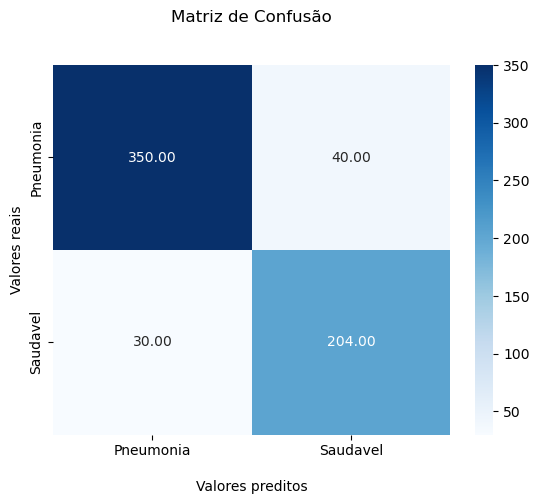

In [31]:
import seaborn as sns

ax = sns.heatmap(con, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Matriz de Confusão\n\n');
ax.set_xlabel('\nValores preditos')
ax.set_ylabel('Valores reais');

ax.xaxis.set_ticklabels(['Pneumonia','Saudavel'])
ax.yaxis.set_ticklabels(['Pneumonia','Saudavel'])

plt.show()